In [138]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Data preparation and validation pipeline

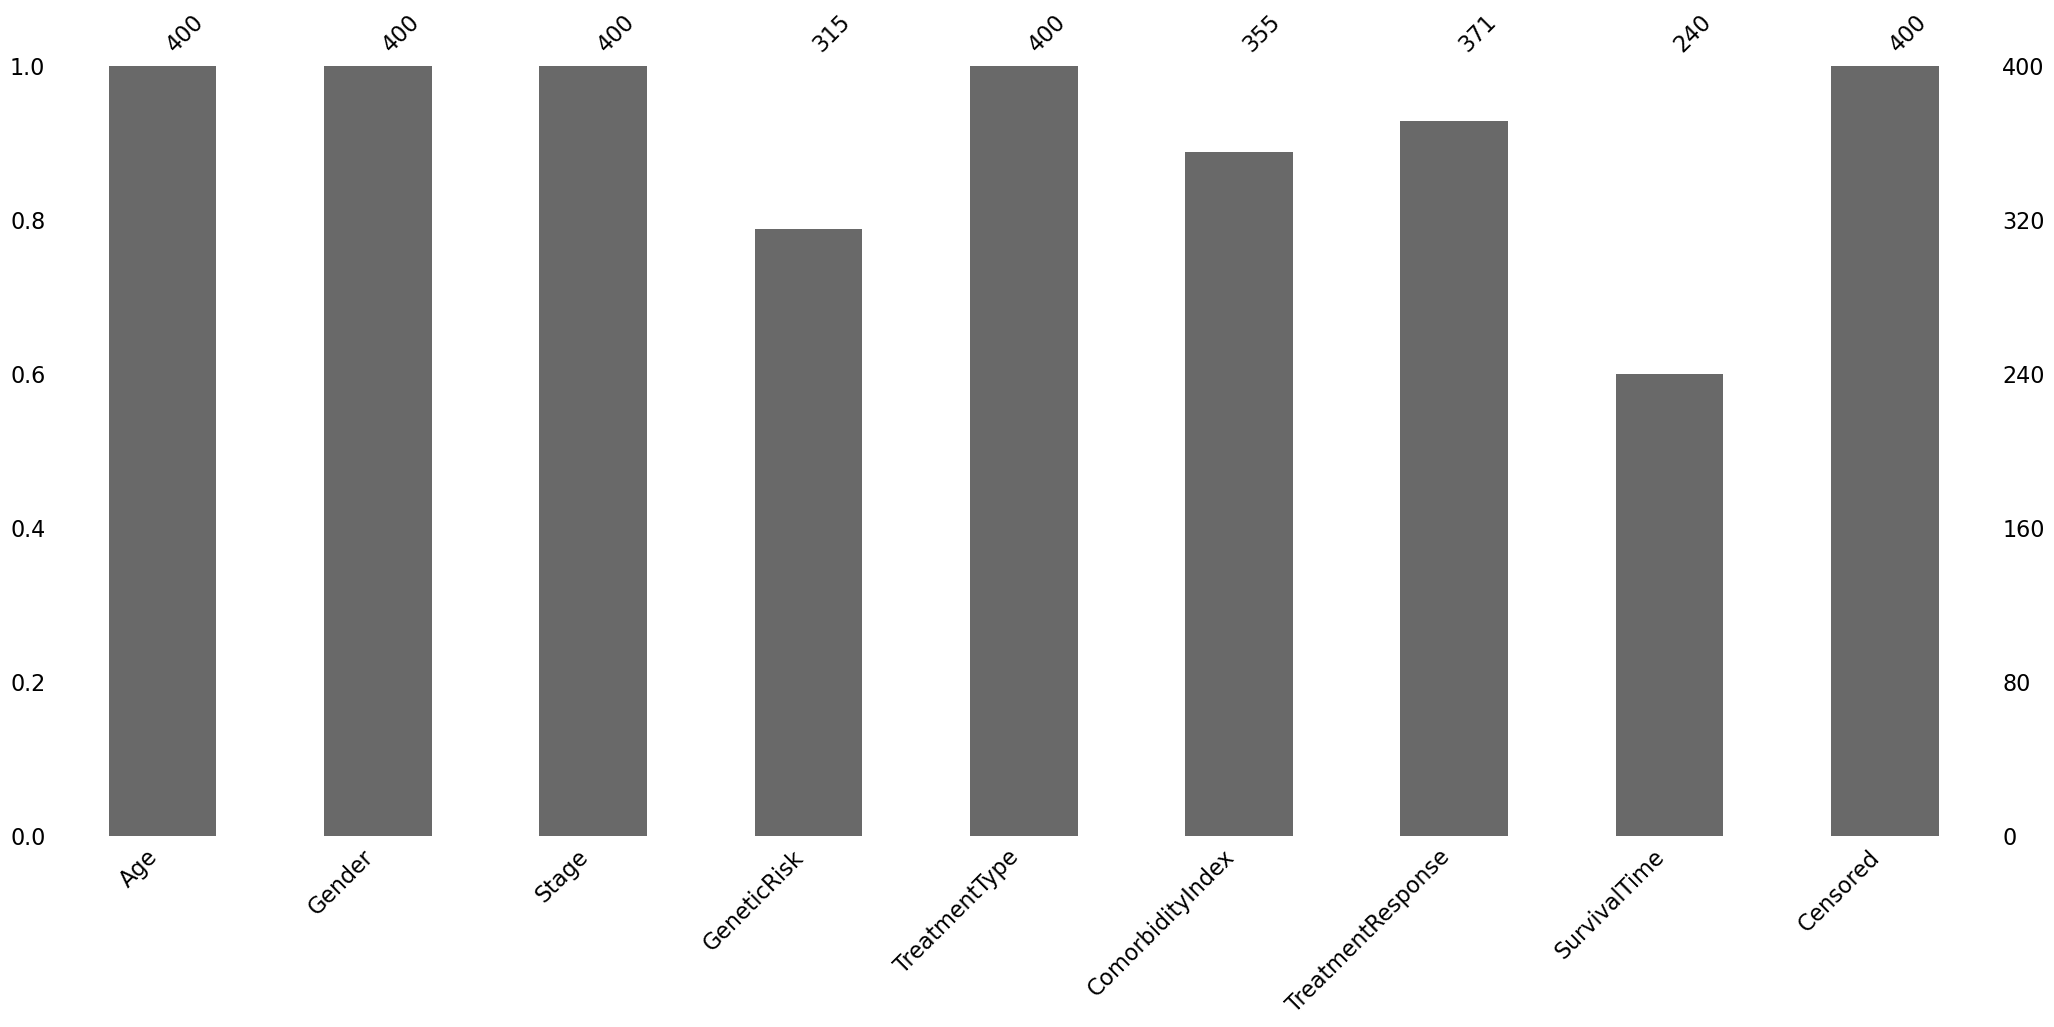

In [140]:
#Data visualization graphs
df = pd.read_csv("train_data.csv", usecols=lambda x: x != "Unnamed: 0")
msno.bar(df)
#msno.heatmap(df)
#msno.matrix(df)
#msno.dendrogram(df)

df_test = pd.read_csv("test_data.csv").drop("id", axis=1)

In [142]:
print(len(df))
print(len(df.dropna()))
#There are 153/400 points left if we remove the rows with at least one missing value.

400
153


In [144]:
#Droping the columns containing the features with missing data and the censored data points or missing survival time
#Columns with missing data
print(df.isna().sum())
#GeneticRisk           85
#ComorbidityIndex      45
#TreatmentResponse     29
#SurvivalTime         160
df_filtered_rows = df[(df['SurvivalTime'].notna()) & (df['Censored'] == 0)]
len(df_filtered_rows)
#400-161=239 rows with censored data points or missing survival times
columns_to_keep = ['SurvivalTime']
columns_to_drop = [col for col in df.columns if col not in columns_to_keep and df[col].isna().any()]
df_cleaned = df_filtered_rows.drop(columns=columns_to_drop)
df_cleaned.shape[1]
#6 columns left

Age                    0
Gender                 0
Stage                  0
GeneticRisk           85
TreatmentType          0
ComorbidityIndex      45
TreatmentResponse     29
SurvivalTime         160
Censored               0
dtype: int64


6

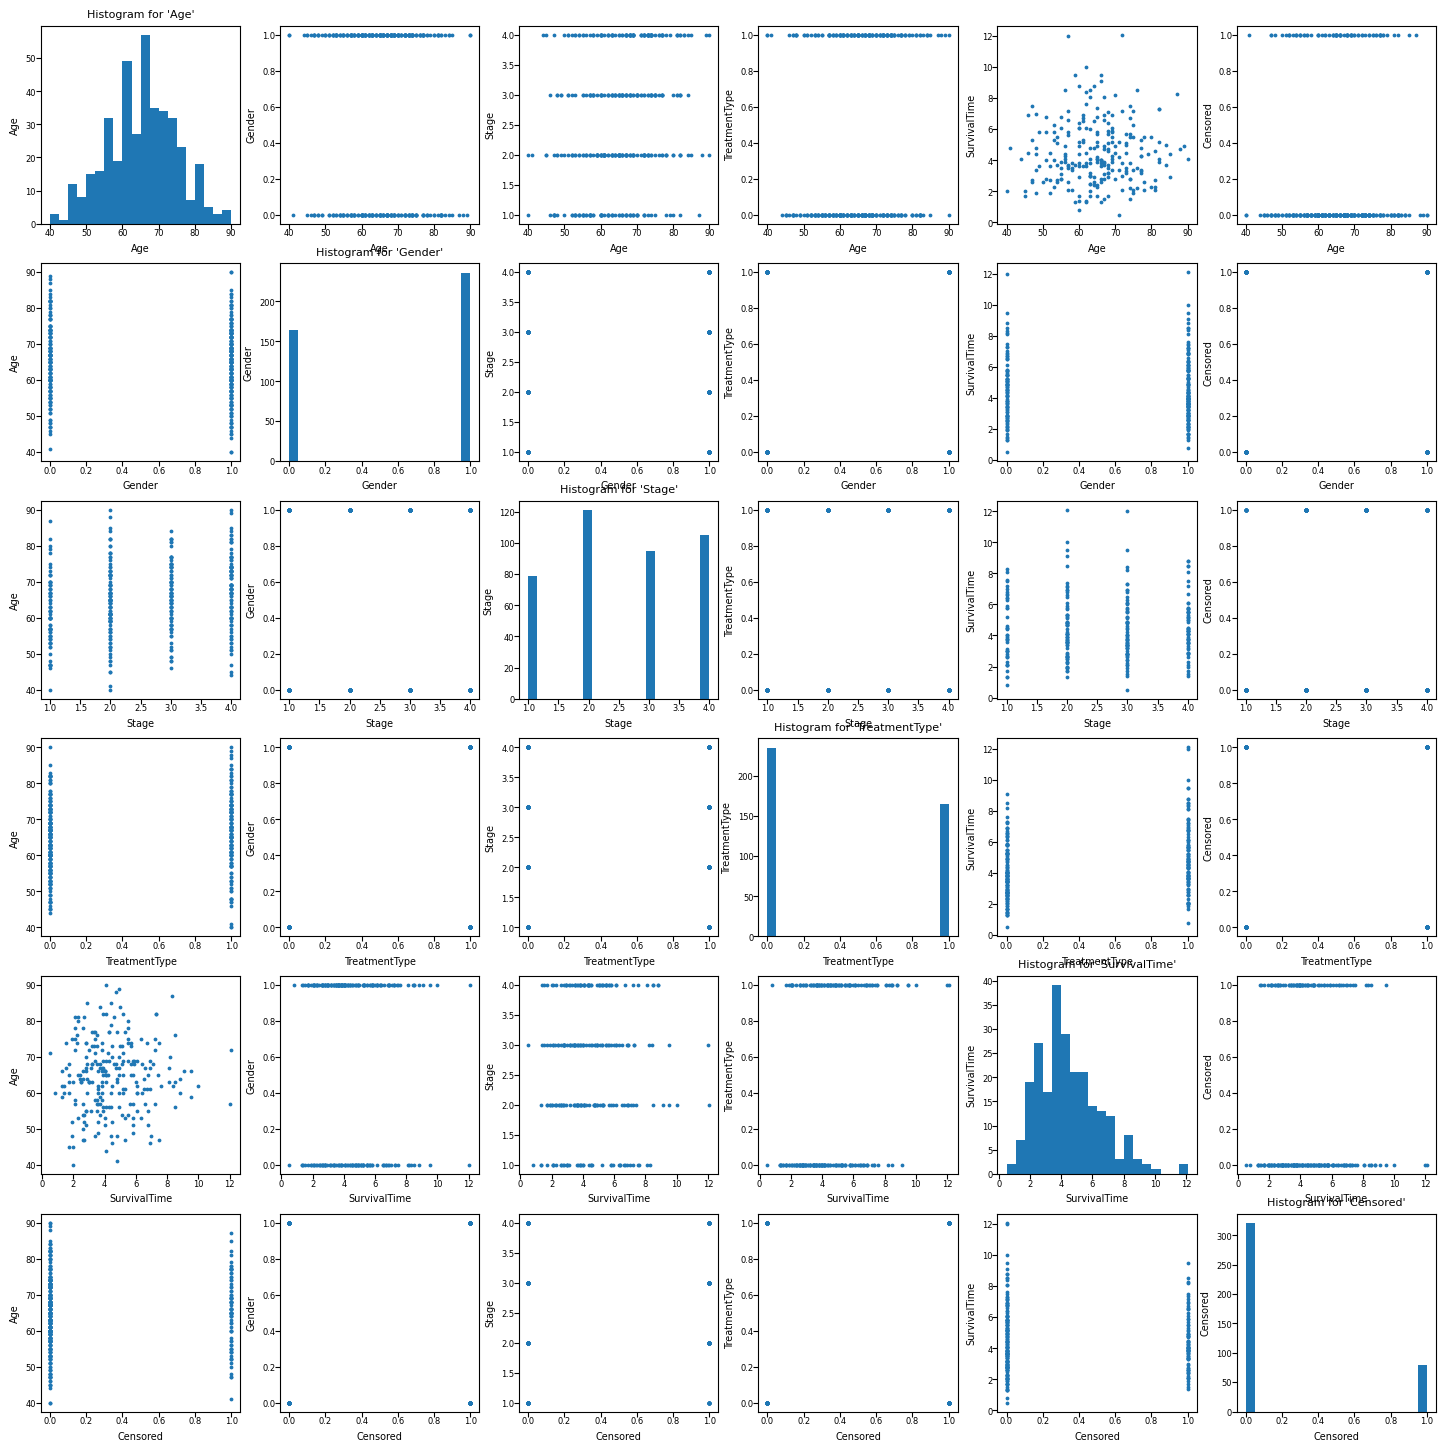

In [146]:
#pairplot between remaining features
columns = df_cleaned.columns
n_columns = len(columns)

fig, axes = plt.subplots(nrows=n_columns, ncols=n_columns, figsize=(18, 18))

for i, col1 in enumerate(columns):
    for j, col2 in enumerate(columns):
        ax = axes[i, j]
        ax.set_xlabel(col1, fontsize=7)
        ax.set_ylabel(col2, fontsize=7)
        ax.tick_params(labelsize=6, pad=0)
        if i == j:
            ax.hist(df[col1], bins=20)
            ax.set_title(f"Histogram for '{col1}'", fontdict={"fontsize": 8})
        else:
            ax.scatter(df[col1], df[col2], s=mpl.rcParams["lines.markersize"] / 2)
plt.show()

In [148]:
#Define the matrix X with the features as columns and examples as rows, and y as a vector with the Survival Time
X = df.loc[:, df.columns != "SurvivalTime"]
y = df["SurvivalTime"]
#Here we considered the original dataframe

In [150]:
#Defining the metric censored Mean Squared Error (cMSE)
def error_metric(y, y_hat, c):
    import numpy as np
    err = y-y_hat
    err = (1-c)*err**2 + c*np.maximum(0,err)**2
    return np.sum(err)/err.shape[0]

In [152]:
#Function to create csv file
def prepare_submission(pipeline, df_test, out_filename):
    y_pred_test = pipeline.predict(df_test)
    y_pred_test_df = pd.DataFrame(y_pred_test, columns=[0])
    y_pred_test_df.insert(0, "id", np.arange(len(y_pred_test)))

    y_pred_test_df.to_csv(out_filename, index=False)

# Learn the baseline model

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold

In [156]:
#Only use uncensored records (Censored == 0)
df_noimpute = df[df.Censored == 0]
#In a real life scenario, you will not have access to the censored variable
#So, we do not include the censored variable as a feature. 
df_noimpute = df_noimpute.drop("Censored", axis=1)

#Find which columns have NaNs
#Drop all rows that have a NaN in the target variable
#Drop the columns with NaNs
#We train with only 161 records
feats_with_nan = [col for col in df.columns[df.isna().any()].tolist() if col != "SurvivalTime"]
df_noimpute = df_noimpute.dropna(subset=["SurvivalTime"])
X_noimpute = df_noimpute.loc[:, df_noimpute.columns != "SurvivalTime"]
X_noimpute = X_noimpute.drop(feats_with_nan, axis=1)
y_noimpute = df_noimpute["SurvivalTime"]

#Baseline with train/test (validation) split
X_train, X_val, y_train, y_val = train_test_split(X_noimpute, y_noimpute, test_size=0.3, random_state=42)
pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipeline_baseline.fit(X_train, y_train)
y_pred = pipeline_baseline.predict(X_val)
mse = root_mean_squared_error(y_pred, y_val) ** 2
print("MSE for train/val: " + str(mse))

#Baseline with CV
pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
cv = LeaveOneOut()
scores = cross_val_score(pipeline_baseline, X_noimpute, y_noimpute, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
print("MSE for leave-one-out CV: " + str(np.abs(scores.mean())))

#Prepare submission
pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("lr", LinearRegression())])
pipeline_baseline.fit(X_noimpute, y_noimpute)
prepare_submission(pipeline_baseline, df_test.dropna(axis=1), "baseline-submission-02.csv")

MSE for train/val: 4.079994656873002
MSE for leave-one-out CV: 4.343603647166121


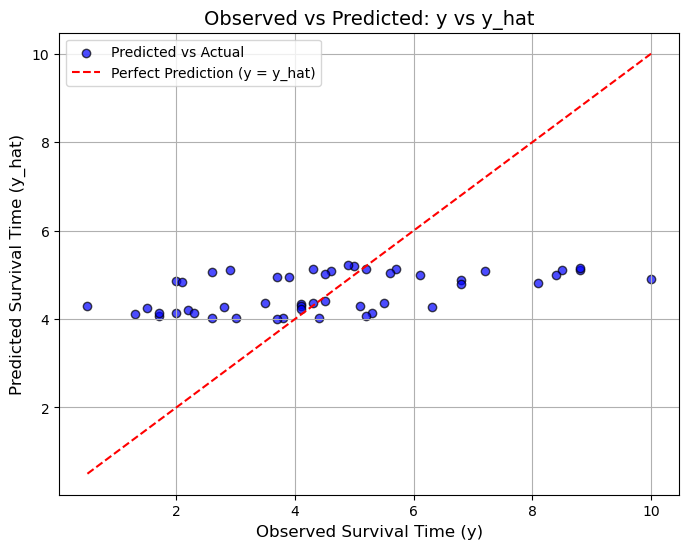

In [88]:
#Plot Observed vs Predicted (y vs y_hat)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7, edgecolors="k", c="blue", label="Predicted vs Actual")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="--", label="Perfect Prediction (y = y_hat)")
    
plt.title("Observed vs Predicted: y vs y_hat", fontsize=14)
plt.xlabel("Observed Survival Time (y)", fontsize=12)
plt.ylabel("Predicted Survival Time (y_hat)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Learn with the cMSE

In [158]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize

def cMSE(y, y_hat, c):
    err = y - y_hat
    loss = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(loss) / len(y)

class CustomLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, c):
        def cMSE(w, X, y, c):
            y_hat = X @ w
            err = y - y_hat
            loss = (1 - c) * err**2 + c * np.maximum(0, err)**2
            return np.sum(loss) / len(y)

        w = np.zeros(X.shape[1] + 1)
        oof = np.hstack((X, np.ones((X.shape[0], 1))))
        result = minimize(cMSE, w, args=(oof, y, c))
        self.w = result.x

        return self
    
    def predict(self, X):
        return np.hstack((X, np.ones((X.shape[0], 1)))) @ self.w

In [160]:
feats_with_nan = [col for col in df.columns[df.isna().any()].tolist() if col != "SurvivalTime"]
df_noimpute = df.dropna(subset=["SurvivalTime"])
X_noimpute = df_noimpute.loc[:, df_noimpute.columns != "SurvivalTime"]
c = X_noimpute["Censored"]
X_noimpute = X_noimpute.drop(feats_with_nan + ["Censored"], axis=1)
y_noimpute = df_noimpute["SurvivalTime"]

N_FOLDS = 5
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
scores = []
for train_idx, val_idx in cv.split(X_noimpute.index):
    X_train, y_train, c_train = X_noimpute.iloc[train_idx], y_noimpute.iloc[train_idx], c.iloc[train_idx]
    X_val, y_val, c_val = X_noimpute.iloc[val_idx], y_noimpute.iloc[val_idx], c.iloc[val_idx]
    pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("lr", CustomLinearRegression())])
    pipeline_baseline.fit(X_train, y_train, lr__c=c_train)
    y_hat = pipeline_baseline.predict(X_val)
    score = cMSE(y_val, y_hat, c_val)
    scores.append(score)
print(f"cMSE using {N_FOLDS}-fold CV: {sum(scores) / N_FOLDS}")
pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("lr", CustomLinearRegression())])
pipeline_baseline.fit(X_noimpute, y_noimpute, lr__c=c)

prepare_submission(pipeline_baseline, df_test.dropna(axis=1), "cMSE-baseline-submission-00.csv")

cMSE using 5-fold CV: 3.3226745010772483


In [162]:
class ManualGradientLR(BaseEstimator, RegressorMixin):

    def __init__(self, lr=0.01, lasso_coef=None, ridge_coef=None):
        self.w = None
        self.lr = lr
        self.lasso_coef = lasso_coef
        self.ridge_coef = ridge_coef

    def compute_gradient(self, X, y, c):
        y_hat = X @ self.w
        N = X.shape[0]
        # 1 if y_i - x_i^T \theta > 0, 0 otherwise
        indicator = np.heaviside(y - y_hat, 0)
        
        gradient = 2 / N * ((1 - c) + c * indicator) * (y_hat - y) @ X
        # regularization
        if self.lasso_coef is not None:
            gradient += self.lasso_coef * np.sign(self.w)
        if self.ridge_coef is not None:
            gradient += 2 * self.ridge_coef * self.w

        score = ((y_hat - y)**2).mean()

        return gradient, score
    
    def fit(self, X, y, c, eps=1e-5):
        # add column for the bias
        X = np.hstack((X.copy(), np.ones((X.shape[0], 1))))
        self.w = np.zeros(X.shape[1])

        prev_score = np.inf
        diff = np.inf

        # iterate until convergence
        while diff > eps:
            gradient, score = self.compute_gradient(X, y, c)
            self.w = self.w - self.lr * gradient

            diff = np.abs(prev_score - score)
            prev_score = score
        
        return self
    
    def predict(self, X):
        return np.hstack((X, np.ones((X.shape[0], 1)))) @ self.w

N_FOLDS = 5
hyperparams_to_try = [
    {},
    {"lasso_coef": 0.01},
    {"lasso_coef": 0.001},
    {"lasso_coef": 0.0001},
    {"ridge_coef": 0.01},
    {"ridge_coef": 0.001},
    {"ridge_coef": 0.0001},
]
for kwargs in hyperparams_to_try:
    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in cv.split(X_noimpute.index):
        X_train, y_train, c_train = X_noimpute.iloc[train_idx], y_noimpute.iloc[train_idx], c.iloc[train_idx]
        X_val, y_val, c_val = X_noimpute.iloc[val_idx], y_noimpute.iloc[val_idx], c.iloc[val_idx]
        pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("lr", ManualGradientLR(**kwargs))])
        pipeline_baseline.fit(X_train, y_train, lr__c=c_train)
        y_hat = pipeline_baseline.predict(X_val)
        score = cMSE(y_val, y_hat, c_val)
        scores.append(score)
    print(f"(ManualGradientLR) cMSE using {N_FOLDS}-fold CV: {sum(scores) / N_FOLDS}")

(ManualGradientLR) cMSE using 5-fold CV: 3.340796686882179
(ManualGradientLR) cMSE using 5-fold CV: 3.3452886754811346
(ManualGradientLR) cMSE using 5-fold CV: 3.3731844455579036
(ManualGradientLR) cMSE using 5-fold CV: 3.3407340861489594
(ManualGradientLR) cMSE using 5-fold CV: 3.3539406317811116
(ManualGradientLR) cMSE using 5-fold CV: 3.3107822443089354
(ManualGradientLR) cMSE using 5-fold CV: 3.3922043038755563


# Nonlinear Models

In [164]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

In [166]:
#Training Polynomial and k-Nearest Neighbors using leave-one-out CV
feats_with_nan = [col for col in df.columns[df.isna().any()].tolist() if col != "SurvivalTime"]
df_noimpute = df.dropna(subset=["SurvivalTime"])
X_noimpute = df_noimpute.loc[:, df_noimpute.columns != "SurvivalTime"]
X_noimpute = X_noimpute.drop(feats_with_nan + ["Censored"], axis=1)
y_noimpute = df_noimpute["SurvivalTime"]

best_score = np.inf
best_model = None

#Testing for different k and d
for k in range(3, 32, 2):
    for d in range(1, 6):
        pipeline_baseline = Pipeline([
            ("scaler", StandardScaler()),
            ("pol", PolynomialFeatures(degree=d)),
            ("knn", KNeighborsRegressor(k))
        ])
        cv = LeaveOneOut()
        scores = cross_val_score(pipeline_baseline, X_noimpute, y_noimpute, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
        mse = np.abs(scores.mean())
        print(f"MSE k=:{k} degree={d} is {mse}", flush=True)

        if mse < best_score:
            best_score = mse
            best_model = (k, d)
#It seems like there aren't meaningful polynomial relationships between the variables

# Prepare submission
k, d = best_model
pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("pol", PolynomialFeatures(degree=d)), ("knn", KNeighborsRegressor(k))])
pipeline_baseline.fit(X_noimpute, y_noimpute)
prepare_submission(pipeline_baseline, df_test.dropna(axis=1), "Nonlinear-submission-00.csv")

MSE k=:3 degree=1 is 4.688587962962964
MSE k=:3 degree=2 is 4.6121944444444445
MSE k=:3 degree=3 is 4.662481481481482
MSE k=:3 degree=4 is 4.67425925925926
MSE k=:3 degree=5 is 4.7276898148148145
MSE k=:5 degree=1 is 4.304678333333333
MSE k=:5 degree=2 is 4.360591666666666
MSE k=:5 degree=3 is 4.3407100000000005
MSE k=:5 degree=4 is 4.299008333333334
MSE k=:5 degree=5 is 4.229768333333334
MSE k=:7 degree=1 is 4.308514455782313
MSE k=:7 degree=2 is 4.313989795918368
MSE k=:7 degree=3 is 4.240847789115646
MSE k=:7 degree=4 is 4.066951530612245
MSE k=:7 degree=5 is 4.010701530612246
MSE k=:9 degree=1 is 4.335600308641975
MSE k=:9 degree=2 is 4.261703189300412
MSE k=:9 degree=3 is 4.182208847736626
MSE k=:9 degree=4 is 4.021835390946502
MSE k=:9 degree=5 is 3.9360689300411518
MSE k=:11 degree=1 is 4.111275482093664
MSE k=:11 degree=2 is 4.100821625344352
MSE k=:11 degree=3 is 4.0865933195592286
MSE k=:11 degree=4 is 3.9826322314049585
MSE k=:11 degree=5 is 3.9355127410468316
MSE k=:13 degr

In [100]:
# Prepare submission
k, d = best_model
print(f"Best model had k={k} and degree={d}")
pipeline_baseline = Pipeline([("scaler", StandardScaler()), ("pol", PolynomialFeatures(degree=d)), ("knn", KNeighborsRegressor(k))])
pipeline_baseline.fit(X_noimpute, y_noimpute)
prepare_submission(pipeline_baseline, df_test.dropna(axis=1), "Nonlinear-submission-00.csv")

Best model had k=19 and degree=1


# Handling Missing Data

In [167]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor

In [168]:
df_noimpute = df.dropna(subset=["SurvivalTime"])
df_noimpute = df_noimpute.drop("Censored", axis=1)
X_noimpute = df_noimpute.loc[:, df_noimpute.columns != "SurvivalTime"]
y_noimpute = df_noimpute["SurvivalTime"]

In [169]:
imp_strategies = [
    SimpleImputer(strategy="mean"),
    SimpleImputer(strategy="median"),
    SimpleImputer(strategy="most_frequent"),
    KNNImputer(weights="uniform"),
    KNNImputer(weights="distance"),
    IterativeImputer()
]

for imp in imp_strategies:
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("imp", imp),
        ("lr", LinearRegression())
    ])
    cv = LeaveOneOut()
    scores = cross_val_score(pipeline, X_noimpute, y_noimpute, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)

    print(f"Score: {np.abs(scores.mean())}")

Score: 3.020967503743139
Score: 3.058734566145377
Score: 3.058734566145377
Score: 3.0696745772551064
Score: 3.072825746774522
Score: 3.028593040741093


Using imputation strategy: SimpleImputer()
MSE for SimpleImputer() strategy: 3.091903313492059


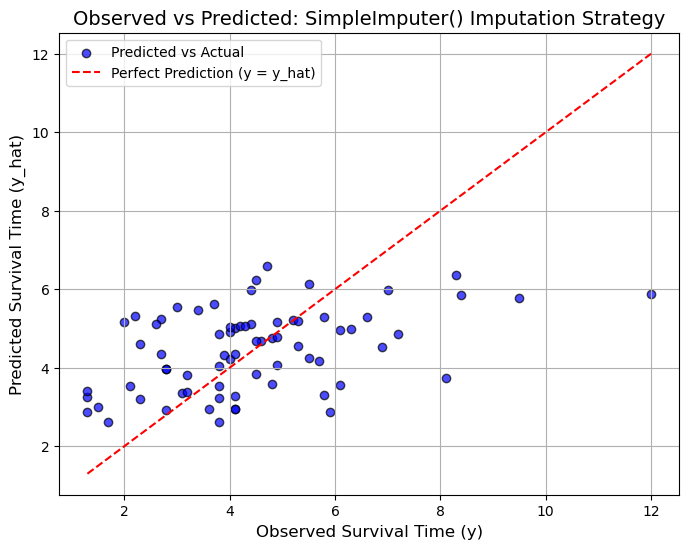

Using imputation strategy: SimpleImputer(strategy='median')
MSE for SimpleImputer(strategy='median') strategy: 3.2534600508740152


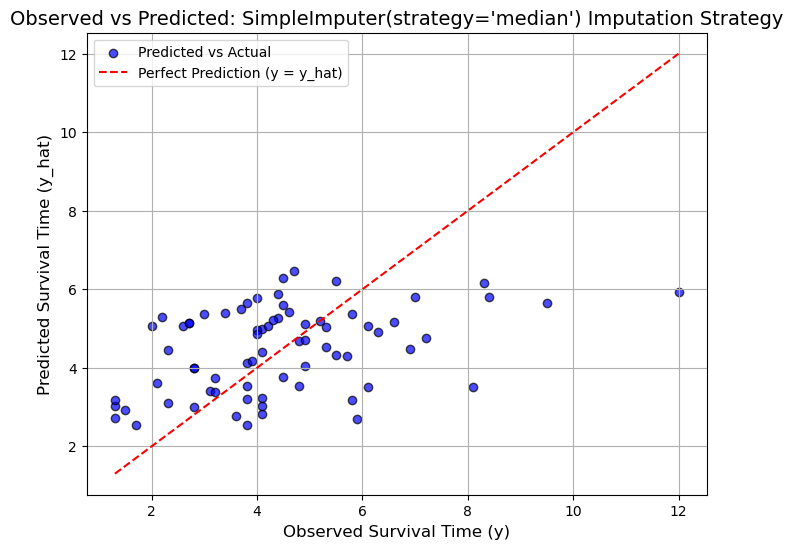

Using imputation strategy: SimpleImputer(strategy='most_frequent')
MSE for SimpleImputer(strategy='most_frequent') strategy: 3.2534600508740152


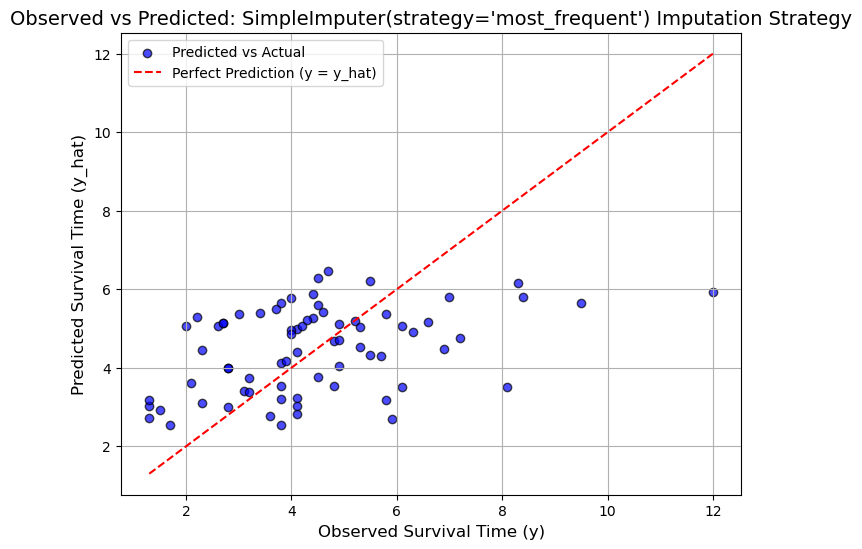

Using imputation strategy: KNNImputer()
MSE for KNNImputer() strategy: 3.1078842179511605


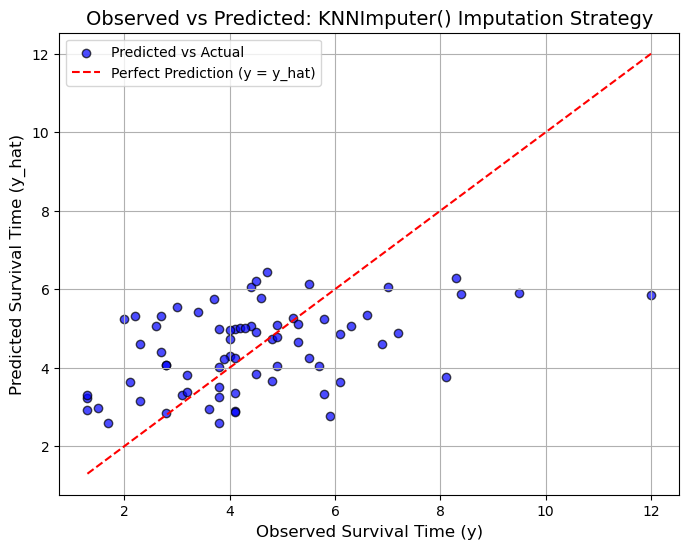

Using imputation strategy: KNNImputer(weights='distance')
MSE for KNNImputer(weights='distance') strategy: 3.114046037609818


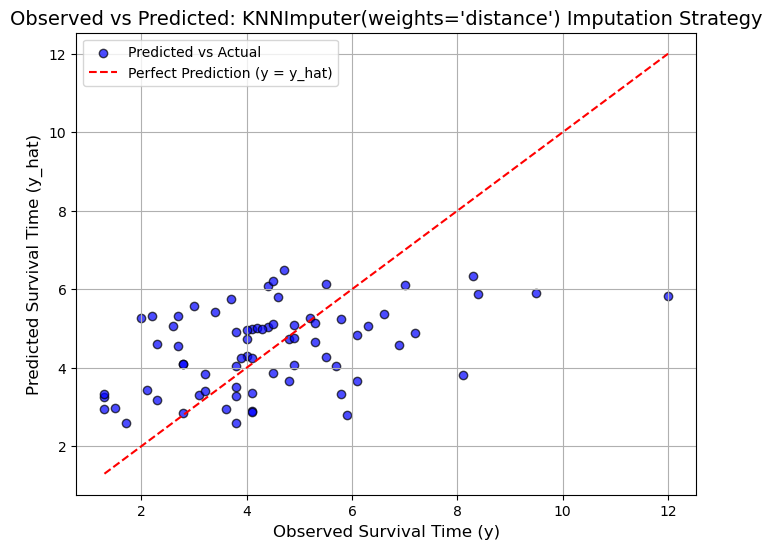

Using imputation strategy: IterativeImputer()
MSE for IterativeImputer() strategy: 3.0993437736902103


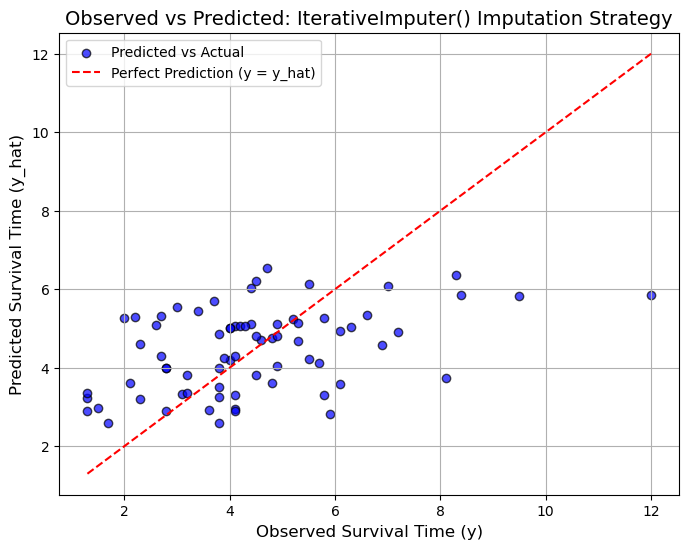

In [174]:
from sklearn.model_selection import LeaveOneOut, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import matplotlib.pyplot as plt
import numpy as np

# List of imputation strategies
imp_strategies = [
    SimpleImputer(strategy="mean"),
    SimpleImputer(strategy="median"),
    SimpleImputer(strategy="most_frequent"),
    KNNImputer(weights="uniform"),
    KNNImputer(weights="distance"),
    IterativeImputer()
]

# Loop through the imputation strategies
for imp in imp_strategies:
    print(f"Using imputation strategy: {imp}")
    
    # Create the pipeline
    pipeline = Pipeline([
        ("imp", imp),
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])
    
    # Split data into train/validation
    X_train, X_val, y_train, y_val = train_test_split(X_noimpute, y_noimpute, test_size=0.3, random_state=42)
    
    # Fit the model on the training data
    pipeline.fit(X_train, y_train)
    
    # Predict on the validation set
    y_pred = pipeline.predict(X_val)
    
    # Compute MSE (Mean Squared Error) on the validation set
    mse = np.mean((y_pred - y_val) ** 2)
    print(f"MSE for {imp} strategy: {mse}")
    
    # Plot Observed vs Predicted (y vs y_hat)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, y_pred, alpha=0.7, edgecolors="k", c="blue", label="Predicted vs Actual")
    plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="--", label="Perfect Prediction (y = y_hat)")
    
    # Customize plot labels and title
    plt.title(f"Observed vs Predicted: {imp} Imputation Strategy", fontsize=14)
    plt.xlabel("Observed Survival Time (y)", fontsize=12)
    plt.ylabel("Predicted Survival Time (y_hat)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


In [132]:
pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
pipeline.fit(X_noimpute, y_noimpute)
prepare_submission(pipeline, df_test, "handle-missing-submission-00.csv")

In [134]:
#Techniques that can directly handle missing data
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("hgbr", HistGradientBoostingRegressor())
])
cv = LeaveOneOut()
scores = cross_val_score(pipeline, X_noimpute, y_noimpute, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
print(f"Hist boosting: {np.abs(scores.mean())}")

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("cbr", CatBoostRegressor())
])
cv = LeaveOneOut()
scores = cross_val_score(pipeline, X_noimpute, y_noimpute, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
print(f"Cat boosting: {np.abs(scores.mean())}")

Hist boosting: 3.7517016034431765
Cat boosting: 3.906626057671076


Hist boosting MSE: 3.734633751815219


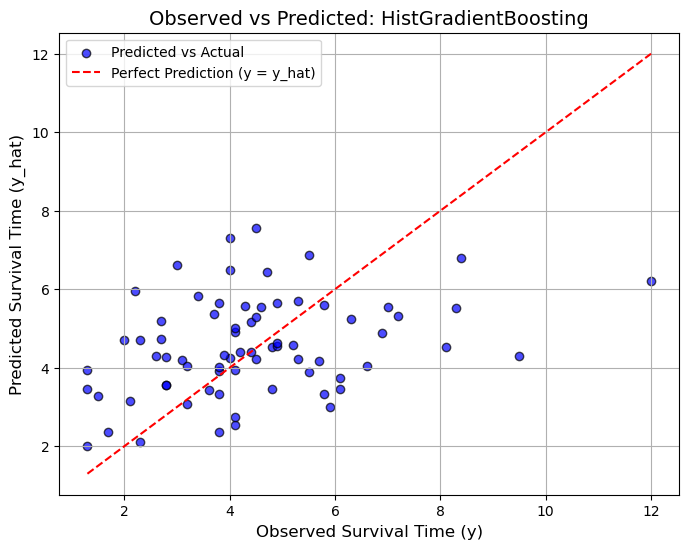

Cat boosting MSE: 4.0884837487023065


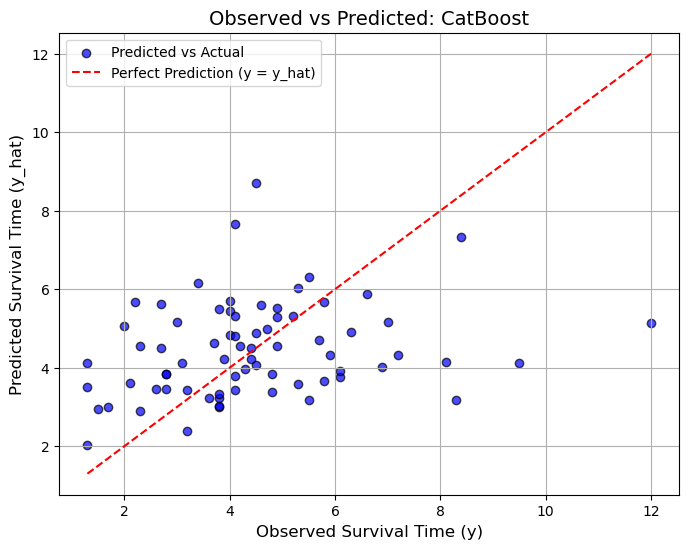

In [135]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_noimpute, y_noimpute, test_size=0.3, random_state=42)

# HistGradientBoostingRegressor
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("hgbr", HistGradientBoostingRegressor())
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipeline.predict(X_val)

# Calculate MSE
mse = np.mean((y_val - y_pred) ** 2)
print(f"Hist boosting MSE: {mse}")

# Plot Observed vs Predicted (y vs y_hat)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7, edgecolors="k", c="blue", label="Predicted vs Actual")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="--", label="Perfect Prediction (y = y_hat)")

plt.title(f"Observed vs Predicted: HistGradientBoosting", fontsize=14)
plt.xlabel("Observed Survival Time (y)", fontsize=12)
plt.ylabel("Predicted Survival Time (y_hat)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# CatBoostRegressor
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("cbr", CatBoostRegressor(verbose=0))  # Disable verbose output for CatBoost
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Predict on the validation set
y_pred = pipeline.predict(X_val)

# Calculate MSE
mse = np.mean((y_val - y_pred) ** 2)
print(f"Cat boosting MSE: {mse}")

# Plot Observed vs Predicted (y vs y_hat)
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.7, edgecolors="k", c="blue", label="Predicted vs Actual")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="red", linestyle="--", label="Perfect Prediction (y = y_hat)")

plt.title(f"Observed vs Predicted: CatBoost", fontsize=14)
plt.xlabel("Observed Survival Time (y)", fontsize=12)
plt.ylabel("Predicted Survival Time (y_hat)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# Semi-Supervised Learning

In [176]:
from sklearn.manifold import Isomap
from sklearn.base import BaseEstimator

class FrozenTransformer(BaseEstimator):
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def __getattr__(self, name):
        # `fitted_transformer`'s attributes are now accessible
        return getattr(self.fitted_transformer, name)

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        # Fitting does not change the state of the estimator
        return self

    def transform(self, X, y=None):
        # transform only transforms the data
        return self.fitted_transformer.transform(X)

    def fit_transform(self, X, y=None):
        # fit_transform only transforms the data
        return self.fitted_transformer.transform(X)

In [178]:
X_imp = df.loc[:, df.columns != "SurvivalTime"]
y = df["SurvivalTime"]
c = X_imp["Censored"].values
X_imp = X_imp.drop(["Censored"], axis=1)

X_columns = X_imp.columns
imp = SimpleImputer(strategy="mean") # KNNImputer(weights="distance")
X_imp = imp.fit_transform(X_imp)

scaler = StandardScaler()
X_imp = scaler.fit_transform(X_imp)

isomap = Isomap(n_neighbors=15, n_components=4)
isomap.fit(X_imp)

idx_nolabel = np.where(y.notna())[0]
X_imp, y, c = X_imp[idx_nolabel], y[idx_nolabel].values, c[idx_nolabel]

print(X_imp.shape)

N_FOLDS = 20
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
scores_mse = []
scores_cmse = []

for train_idx, val_idx in cv.split(X_imp):
    X_train, y_train, c_train = X_imp[train_idx], y[train_idx], c[train_idx]
    X_val, y_val, c_val = X_imp[val_idx], y[val_idx], c[val_idx]
    pipeline = Pipeline([
        ("imputer", imp),
        ("scaler", StandardScaler()),
        ("dr", FrozenTransformer(isomap)),
        ("lr", CustomLinearRegression())
    ])
    pipeline.fit(X_train, y_train, lr__c=c_train)
    y_hat = pipeline.predict(X_val)
    scores_mse.append(((y_val - y_hat)**2).mean())
    scores_cmse.append(cMSE(y_val, y_hat, c_val))
print(f"MSE using {N_FOLDS}-fold CV: {sum(scores_mse) / N_FOLDS}")
print(f"cMSE using {N_FOLDS}-fold CV: {sum(scores_cmse) / N_FOLDS}")

scores_mse = []
for train_idx, val_idx in cv.split(X_imp):
    X_train, y_train = X_imp[train_idx], y[train_idx]
    X_val, y_val = X_imp[val_idx], y[val_idx]
    pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("dr", FrozenTransformer(isomap)),
        ("lr", LinearRegression())
    ])
    pipeline.fit(X_train, y_train)
    y_hat = pipeline.predict(X_val)
    scores_mse.append(((y_val - y_hat)**2).mean())
print(f"MSE using {N_FOLDS}-fold CV: {sum(scores_mse) / N_FOLDS}")

X_imp = pd.DataFrame(X_imp, columns=X_columns)
pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="mean")),
    ("scaler", scaler),
    ("dr", FrozenTransformer(isomap)),
    ("lr", LinearRegression())
])
pipeline.fit(X_imp, y)
prepare_submission(pipeline, df_test, "semisupervised-submission-03.csv")

(240, 7)
MSE using 20-fold CV: 3.0470573361201168
cMSE using 20-fold CV: 2.3878950142476305
MSE using 20-fold CV: 2.940491330452336
